# Training a random medium by a complex medium to generate a target coherent state

Use the multi-heads (2-head) gates in the phase space 
to create a network that represent a coherent state 
propagating in a random medium. 
Use a trainable complex medium to obtain a target state

NOTE: remember to shut down the kernel when out of memory

<img src="../img/coherentcomplextraining.png" width="900" height="300" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 22 july 2020<br>
@version 23 sep 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

Set the precision for the output

In [4]:
np.set_printoptions(precision=4)

## Dimension

In [5]:
N = 20

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N, name = 'Vacuum')

## Build the pullback layer for generating the input coherent state

### Target displacement vector (IMPORTANT THE DISPLACEMENT VECTOR MUST BE NORMALIZED!!!)
The displacement vector is a normalized column vector

In [7]:
dinput = 3.0*np.ones((N,1)); 

Normalize the dinput (this is needed as we want to training with constant photon number, the target displacement and the input must have the same norm)

In [8]:
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())
print(np.dot(dinput.transpose(), dinput))

[[0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236
  0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236 0.2236]]
[[1.]]


## Define the linear Glauber layer
The layer is a constant layer, as no training is needed

In [9]:
D = ps.DisplacementLayerConstant(dinput, name = 'GlauberLayer')

## Define the layer for the untrainable complex medium
We can give a name to the layer to appear in the model summary

In [10]:
R = ps.RandomLayerConstant(N, name = 'RandomLayerConstant')

## Define the trainable random layer

In [11]:
T = ps.RandomLayer(N, name='RandomLayer')

## Define the normalize target displacement vector <br>
The target displacement vector must have the same norm of the input as the photon number is conserved

In [12]:
dtarget = np.zeros((N,1)); dtarget[0]=3.14; dtarget[1]=1.0; 
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[0.9528 0.3035 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


## Connect the layers (in reverse order)

In [13]:
xin = tf.keras.layers.Input(N)
x3, a3 = R(xin)
x2, a2 = T(x3, a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1)

In [14]:
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

## Test the model by derivatives

In [15]:
xzero = tf.constant(np.zeros((1,N)))
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xzero)
    chir, chii = model(xzero)         

In [16]:
tf.print(tape.gradient(chir,xzero))

[[0 0 0 ... 0 0 0]]


In [17]:
tf.print(tape.gradient(chii,xzero))

[[-0.21607400476932526 0.0488644577562809 -0.31387889385223389 ... -0.28683149814605713 -0.31151878833770752 -0.050944756716489792]]


## Build the training set by using a target characteristic function

Number of training points

In [18]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement

In [19]:
def chi_target(x, d):
    """ Characteristic function of a Gaussian coherent state
    Parameters
    ----------
    :param x: input
    :param d: displacement vector
    """
    yr = -0.25*np.matmul(x, x.transpose())
    yi = np.matmul(x, d)
    #return yr, yi
    return np.exp(yr)*np.cos(yi), np.exp(yr)*np.sin(yi)

Generate the training set

In [20]:
xtrain = np.random.rand(Nbatch, N)-0.5
chitestr = np.zeros(Nbatch)
chitesti = np.zeros(Nbatch)
for j in range(Nbatch):
    chitestr[j], chitesti[j] = chi_target(xtrain[j], dtarget)

## Train the model

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 RandomLayerConstant (RandomLay  [(None, 20),        200         ['input_1[0][0]']                
 er)                             (20, 1)]                                                         
                                                                                                  
 RandomLayer (RandomLayer)      [(None, 20),         200         ['RandomLayerConstant[0][0]',    
                                 (20, 1)]                         'RandomLayerConstant[0][1]']    
                                                                                              

Note the model as 200 trainable weight, corresponding to random layer 1, which is the only trainable

In [23]:
history=model.fit(x=xtrain, y=(chitestr, chitesti), epochs=100, verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 4ms/step - loss: 0.0808 - Vacuum_loss: 0.0019 - Vacuum_1_loss: 0.0789
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0732 - Vacuum_loss: 0.0019 - Vacuum_1_loss: 0.0713
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0663 - Vacuum_loss: 0.0022 - Vacuum_1_loss: 0.0641
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0602 - Vacuum_loss: 0.0023 - Vacuum_1_loss: 0.0579
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0555 - Vacuum_loss: 0.0021 - Vacuum_1_loss: 0.0534
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0535 - Vacuum_loss: 0.0019 - Vacuum_1_loss: 0.0515
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0514 - Vacuum_loss: 0.0018 - Vacuum_1_loss: 0.0496
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0486 - Vacuum_loss: 0.0017 - Vacuum_1_loss: 0.0469
Epoch 9/

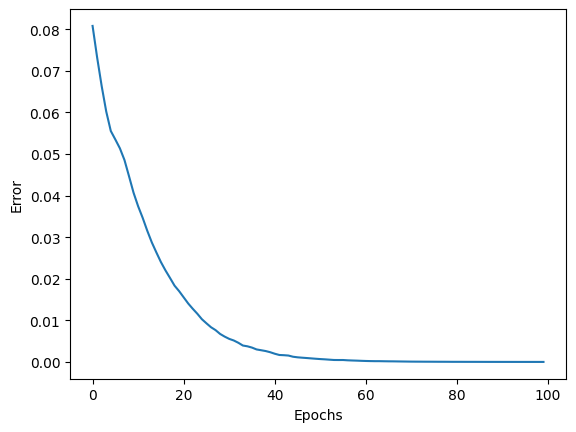

In [24]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
#plt.subplot(2, 1s'])
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.savefig('training1.pdf')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [25]:
#x = tf.constant(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(xzero)
    chir, chii = model(xzero)

In [26]:
print(tape.gradient(chir,xzero))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 20), dtype=float64)


## Compare the derivative of the chi and the target vector

In [27]:
tf.print(tape.gradient(chii,xzero))

[[0.95324116945266724 0.30203521251678467 -0.0023171333596110344 ... 0.00096286879852414131 -0.0017163989832624793 0.0011690058745443821]]


In [28]:
print(dtarget.transpose())

[[0.9528 0.3035 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
